# Ionosphere Data Normalization Comparison

This notebook compares the original absolute maximum normalization with the new mean-sigma + tanh normalization method using the **EXACT same data loading as your training script**.

## Key Questions to Answer:
1. How do the statistics compare between the two methods?
2. Is the mean-sigma + tanh normalization reversible?
3. How does the data distribution change with each method?
4. Which method preserves more information?
5. **BONUS**: How does raw (non-transformed) data look?

In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import os

# Add src to path to import dataset module
sys.path.append(os.path.join(os.getcwd(), 'src'))

from src.data.dataset import get_sequence_data_objects, MeanSigmaTanhNormalizer

# Set up plotting
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")

print("✓ Imports successful")

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


✓ Imports successful


## 1. Load Data EXACTLY Like Training Script

In [ ]:
# Define the paths exactly as in your training script
CSV_PATH = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/npy_metrics.csv"
TRANSFORM_COND_CSV = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv"
SEQUENCE_LENGTH = 30  # Same as training
BATCH_SIZE = 4  # Small batch for analysis

print("Loading datasets exactly as in training script...")
print(f"Using sequence length: {SEQUENCE_LENGTH}")
print(f"CSV path: {CSV_PATH}")
print(f"Transform CSV: {TRANSFORM_COND_CSV}")

# 1. Load RAW data (no transforms)
print("\n🔴 1. Loading RAW data (transforms=False)...")
raw_dataset, raw_sampler, raw_dl = get_sequence_data_objects(
    csv_path=CSV_PATH,
    transform_cond_csv=TRANSFORM_COND_CSV,
    batch_size=BATCH_SIZE,
    distributed=False,
    num_data_workers=0,  # Set to 0 for notebook
    split='train',
    seed=42,
    sequence_length=SEQUENCE_LENGTH,
    transforms=False,  # 🚨 NO TRANSFORMS - RAW DATA
    normalization_type="absolute_max"  # Doesn't matter since transforms=False
)

# 2. Load with ABSOLUTE MAX normalization (like original)
print("\n🟠 2. Loading with ABSOLUTE MAX normalization...")
abs_dataset, abs_sampler, abs_dl = get_sequence_data_objects(
    csv_path=CSV_PATH,
    transform_cond_csv=TRANSFORM_COND_CSV,
    batch_size=BATCH_SIZE,
    distributed=False,
    num_data_workers=0,
    split='train',
    seed=42,
    sequence_length=SEQUENCE_LENGTH,
    transforms=True,
    normalization_type="absolute_max"  # Original method
)

# 3. Load with MEAN-SIGMA + TANH normalization (new method)
print("\n🟢 3. Loading with MEAN-SIGMA + TANH normalization...")
tanh_dataset, tanh_sampler, tanh_dl = get_sequence_data_objects(
    csv_path=CSV_PATH,
    transform_cond_csv=TRANSFORM_COND_CSV,
    batch_size=BATCH_SIZE,
    distributed=False,
    num_data_workers=0,
    split='train',
    seed=42,
    sequence_length=SEQUENCE_LENGTH,
    transforms=True,
    normalization_type="mean_sigma_tanh"  # 🚨 NEW METHOD
)

print(f"\n✅ All datasets loaded successfully!")
print(f"  Raw dataset: {len(raw_dataset)} sequences")
print(f"  Abs Max dataset: {len(abs_dataset)} sequences") 
print(f"  Tanh dataset: {len(tanh_dataset)} sequences")

# Show normalizer info if available
if tanh_dataset.normalizer is not None:
    stats = tanh_dataset.normalizer.get_stats()
    print(f"\n📊 Tanh Normalizer Stats:")
    print(f"  Mean: {stats['mean']:.2f}")
    print(f"  Std: {stats['std']:.2f}")

Loading datasets exactly as in training script...
Using sequence length: 120
CSV path: /mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/npy_metrics.csv
Transform CSV: /mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/params.csv

🔴 1. Loading RAW data (transforms=False)...

🟠 2. Loading with ABSOLUTE MAX normalization...

🟢 3. Loading with MEAN-SIGMA + TANH normalization...
Fitting sequence normalizer on 10 sequences...
Sequence normalizer fitted: mean=-3517.47, std=9913.06

✅ All datasets loaded successfully!
  Raw dataset: 1220 sequences
  Abs Max dataset: 1220 sequences
  Tanh dataset: 1220 sequences

📊 Tanh Normalizer Stats:
  Mean: -3517.47
  Std: 9913.06


## 2. Load Sample Batches for Comparison

In [3]:
# Load one batch from each dataset
print("Loading sample batches...")

# Get one batch from each dataloader
raw_batch = next(iter(raw_dl))
abs_batch = next(iter(abs_dl))
tanh_batch = next(iter(tanh_dl))

# Extract data tensors (ignore conditions for now)
raw_data, raw_cond = raw_batch
abs_data, abs_cond = abs_batch
tanh_data, tanh_cond = tanh_batch

print(f"\n📊 Batch shapes:")
print(f"  Raw data: {raw_data.shape}")
print(f"  Abs data: {abs_data.shape}")
print(f"  Tanh data: {tanh_data.shape}")
print(f"  Conditions: {raw_cond.shape}")

# Take a subset for detailed analysis (first sample, first few time steps)
# Shape is [batch, sequence_length, height, width]
sample_frames = 5  # Analyze first 5 frames
raw_sample = raw_data[0, :sample_frames]  # [5, 24, 360]
abs_sample = abs_data[0, :sample_frames]  # [5, 24, 360]
tanh_sample = tanh_data[0, :sample_frames]  # [5, 24, 360]

print(f"\n🔍 Sample analysis shapes:")
print(f"  Raw sample: {raw_sample.shape}")
print(f"  Abs sample: {abs_sample.shape}")
print(f"  Tanh sample: {tanh_sample.shape}")

Loading sample batches...

📊 Batch shapes:
  Raw data: torch.Size([4, 120, 1, 24, 360])
  Abs data: torch.Size([4, 120, 1, 24, 360])
  Tanh data: torch.Size([4, 120, 1, 24, 360])
  Conditions: torch.Size([4, 120, 4])

🔍 Sample analysis shapes:
  Raw sample: torch.Size([5, 1, 24, 360])
  Abs sample: torch.Size([5, 1, 24, 360])
  Tanh sample: torch.Size([5, 1, 24, 360])


## 3. Statistics Comparison

In [4]:
def compute_stats(data, name):
    """Compute and display statistics for a dataset."""
    stats = {
        'name': name,
        'shape': list(data.shape),
        'min': data.min().item(),
        'max': data.max().item(),
        'mean': data.mean().item(),
        'std': data.std().item(),
        'median': data.median().item(),
        'q25': data.quantile(0.25).item(),
        'q75': data.quantile(0.75).item()
    }
    return stats

# Compute statistics for each method
raw_stats = compute_stats(raw_sample, "Raw Data (No Transform)")
abs_stats = compute_stats(abs_sample, "Absolute Max Normalization")
tanh_stats = compute_stats(tanh_sample, "Mean-Sigma + Tanh Normalization")

# Create comparison DataFrame
stats_df = pd.DataFrame([raw_stats, abs_stats, tanh_stats])
stats_df = stats_df.round(6)

print("📊 STATISTICS COMPARISON")
print("=" * 80)
print(stats_df.to_string(index=False))

print(f"\n📈 KEY OBSERVATIONS:")
print(f"• Raw data range: [{raw_stats['min']:.1f}, {raw_stats['max']:.1f}] (span: {raw_stats['max']-raw_stats['min']:.1f})")
print(f"• Absolute max range: [{abs_stats['min']:.6f}, {abs_stats['max']:.6f}]")
print(f"• Mean-sigma + tanh range: [{tanh_stats['min']:.6f}, {tanh_stats['max']:.6f}]")
print(f"• Tanh bounded in [-1,1]: {tanh_stats['min'] >= -1.0 and tanh_stats['max'] <= 1.0}")
print(f"• Tanh preserves more variance: {tanh_stats['std']:.6f} vs {abs_stats['std']:.6f}")

📊 STATISTICS COMPARISON
                           name           shape           min          max        mean         std    median          q25         q75
        Raw Data (No Transform) [5, 1, 24, 360] -13861.200195 10800.200195 -213.485977 4729.408691 33.549999 -2998.437500 2980.147461
     Absolute Max Normalization [5, 1, 24, 360]     -0.128162     0.099859   -0.001974    0.043728  0.000310    -0.027724    0.027555
Mean-Sigma + Tanh Normalization [5, 1, 24, 360]     -0.779244     0.894565    0.278625    0.386596  0.343642     0.052311    0.575335

📈 KEY OBSERVATIONS:
• Raw data range: [-13861.2, 10800.2] (span: 24661.4)
• Absolute max range: [-0.128162, 0.099859]
• Mean-sigma + tanh range: [-0.779244, 0.894565]
• Tanh bounded in [-1,1]: True
• Tanh preserves more variance: 0.386596 vs 0.043728


## 4. Test Reversibility of Tanh Normalization

In [5]:
# Test reversibility using the dataset's reverse function
print("🔄 TESTING REVERSIBILITY")
print("=" * 50)

if hasattr(tanh_dataset, 'reverse_data_normalization') and tanh_dataset.normalizer is not None:
    print("✓ Found reverse normalization function")
    
    # Test reversibility on our tanh-normalized sample
    print("\nTesting reversibility...")
    
    # Reverse the tanh normalization
    recovered_sample = tanh_dataset.reverse_data_normalization(tanh_sample)
    
    # Compare with original raw data
    abs_error = torch.abs(raw_sample - recovered_sample)
    max_abs_error = abs_error.max().item()
    mean_abs_error = abs_error.mean().item()
    
    # Relative error (avoid division by zero)
    mask = torch.abs(raw_sample) > 1e-6
    rel_error = torch.zeros_like(raw_sample)
    rel_error[mask] = abs_error[mask] / torch.abs(raw_sample[mask])
    max_rel_error = rel_error.max().item()
    mean_rel_error = rel_error[mask].mean().item() if mask.any() else 0.0
    
    print(f"\n📏 REVERSIBILITY RESULTS:")
    print(f"• Maximum absolute error: {max_abs_error:.6f}")
    print(f"• Mean absolute error: {mean_abs_error:.6f}")
    print(f"• Maximum relative error: {max_rel_error:.6f} ({max_rel_error*100:.4f}%)")
    print(f"• Mean relative error: {mean_rel_error:.6f} ({mean_rel_error*100:.4f}%)")
    
    # Test if reversibility is acceptable
    abs_threshold = 1.0  # 1 unit absolute error
    rel_threshold = 1e-4  # 0.01% relative error
    
    is_reversible = max_abs_error < abs_threshold and max_rel_error < rel_threshold
    
    if is_reversible:
        print(f"\n✅ REVERSIBILITY TEST PASSED!")
        print(f"   Errors are within acceptable thresholds.")
    else:
        print(f"\n⚠️  REVERSIBILITY CONCERNS:")
        if max_abs_error >= abs_threshold:
            print(f"   • Absolute error {max_abs_error:.6f} >= {abs_threshold}")
        if max_rel_error >= rel_threshold:
            print(f"   • Relative error {max_rel_error:.6f} >= {rel_threshold}")
            
    # Store for later use
    globals()['recovered_sample'] = recovered_sample
    globals()['is_reversible'] = is_reversible
    globals()['max_abs_error'] = max_abs_error
    globals()['max_rel_error'] = max_rel_error
            
else:
    print("❌ No reverse normalization function found!")
    recovered_sample = None

🔄 TESTING REVERSIBILITY
✓ Found reverse normalization function

Testing reversibility...

📏 REVERSIBILITY RESULTS:
• Maximum absolute error: 0.002441
• Mean absolute error: 0.000210
• Maximum relative error: 0.005046 (0.5046%)
• Mean relative error: 0.000001 (0.0001%)

⚠️  REVERSIBILITY CONCERNS:
   • Relative error 0.005046 >= 0.0001


## 5. Visual Comparison

Visualizing time step 0 as polar plots...
Data shapes after squeeze: (24, 360)
\nRecovery Quality:
• Max absolute difference: 0.001465
• Mean absolute difference: 0.000124


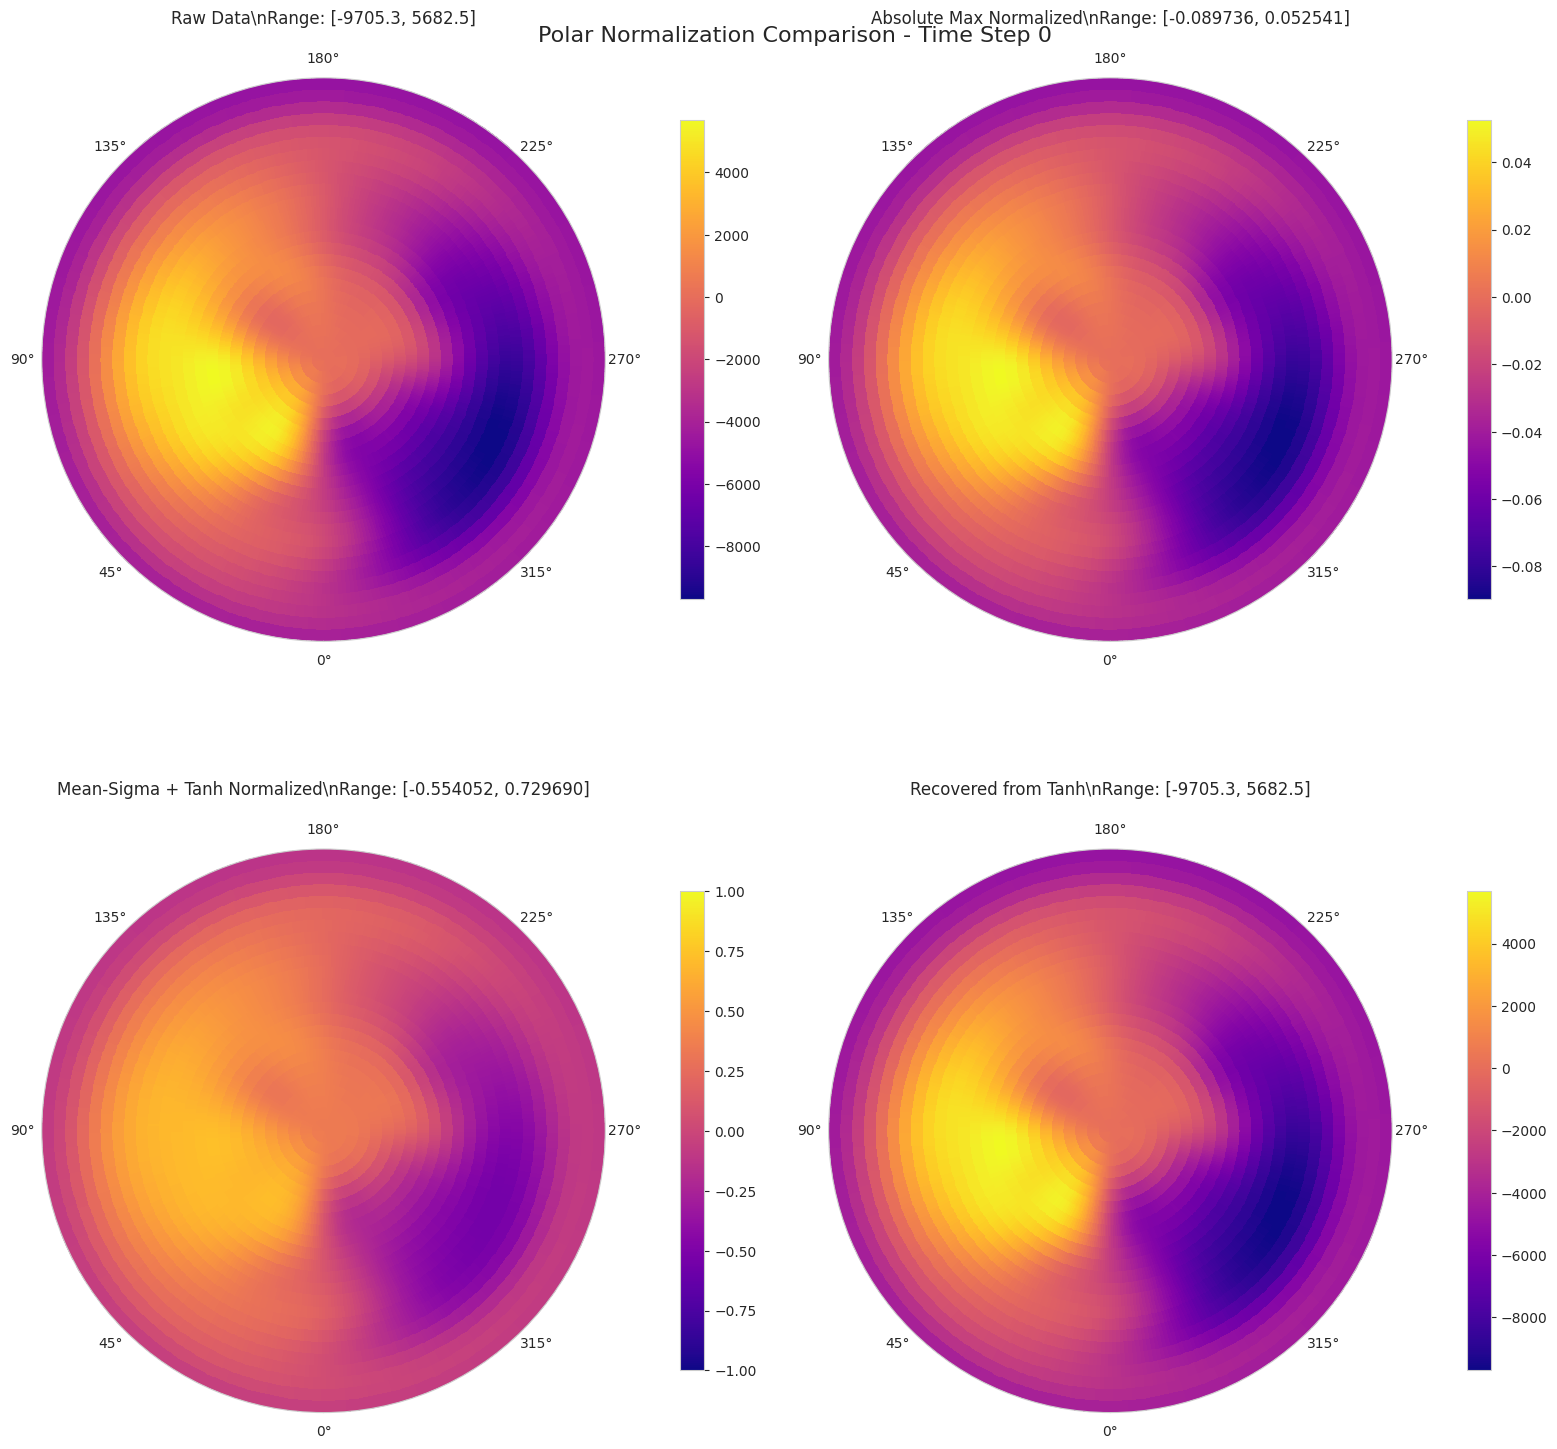

\nData Statistics:
• Raw data range: [-9705.3, 5682.5]
• Abs normalized range: [-0.089736, 0.052541]
• Tanh normalized range: [-0.554052, 0.729690]
• Recovered range: [-9705.3, 5682.5]


In [7]:
# Visualize one time step from the sequence as polar plots
time_step = 0  # First time step
print(f"Visualizing time step {time_step} as polar plots...")

# Get 2D slices [24, 360] and squeeze out any extra dimensions
raw_slice = raw_sample[time_step].numpy().squeeze()
abs_slice = abs_sample[time_step].numpy().squeeze()
tanh_slice = tanh_sample[time_step].numpy().squeeze()

print(f"Data shapes after squeeze: {raw_slice.shape}")

# Get recovered slice if available
if 'recovered_sample' in globals() and recovered_sample is not None:
    recovered_slice = recovered_sample[time_step].numpy().squeeze()
    n_plots = 4
    fig, axes = plt.subplots(2, 2, figsize=(16, 16), subplot_kw={'projection': 'polar'})
    axes = axes.flatten()
else:
    recovered_slice = None
    n_plots = 3
    fig, axes = plt.subplots(1, 3, figsize=(20, 7), subplot_kw={'projection': 'polar'})

# Create polar coordinate grids for ionosphere data
# Latitude range: -90 to -66 degrees (24 points)
# Longitude range: 0 to 360 degrees (360 points)
mag_lat = np.linspace(-90, -66, raw_slice.shape[0])  # 24 latitude points
mag_lon = np.linspace(0, 360, raw_slice.shape[1], endpoint=False)  # 360 longitude points

# Create meshgrid for coordinates
lon_grid, lat_grid = np.meshgrid(mag_lon, mag_lat)

# Convert to polar coordinates (r = 90 - |latitude|, theta = longitude in radians)
r = 90 - np.abs(lat_grid)
theta = np.deg2rad(lon_grid)

# Plot raw data
im1 = axes[0].pcolormesh(theta, r, raw_slice, shading='auto', cmap='plasma')
axes[0].set_theta_zero_location("S")  # South at top
axes[0].set_theta_direction(-1)  # Clockwise
axes[0].set_title(f'Raw Data\\nRange: [{raw_slice.min():.1f}, {raw_slice.max():.1f}]', pad=20)
plt.colorbar(im1, ax=axes[0], shrink=0.6, pad=0.1)

# Plot absolute max normalized
im2 = axes[1].pcolormesh(theta, r, abs_slice, shading='auto', cmap='plasma')
axes[1].set_theta_zero_location("S")
axes[1].set_theta_direction(-1)
axes[1].set_title(f'Absolute Max Normalized\\nRange: [{abs_slice.min():.6f}, {abs_slice.max():.6f}]', pad=20)
plt.colorbar(im2, ax=axes[1], shrink=0.6, pad=0.1)

# Plot tanh normalized
im3 = axes[2].pcolormesh(theta, r, tanh_slice, shading='auto', cmap='plasma', vmin=-1, vmax=1)
axes[2].set_theta_zero_location("S")
axes[2].set_theta_direction(-1)
axes[2].set_title(f'Mean-Sigma + Tanh Normalized\\nRange: [{tanh_slice.min():.6f}, {tanh_slice.max():.6f}]', pad=20)
plt.colorbar(im3, ax=axes[2], shrink=0.6, pad=0.1)

# Plot recovered if available
if recovered_slice is not None:
    im4 = axes[3].pcolormesh(theta, r, recovered_slice, shading='auto', cmap='plasma')
    axes[3].set_theta_zero_location("S")
    axes[3].set_theta_direction(-1)
    axes[3].set_title(f'Recovered from Tanh\\nRange: [{recovered_slice.min():.1f}, {recovered_slice.max():.1f}]', pad=20)
    plt.colorbar(im4, ax=axes[3], shrink=0.6, pad=0.1)
    
    # Show difference
    diff = np.abs(raw_slice - recovered_slice)
    print(f"\\nRecovery Quality:")
    print(f"• Max absolute difference: {diff.max():.6f}")
    print(f"• Mean absolute difference: {diff.mean():.6f}")

plt.tight_layout()
plt.suptitle(f'Polar Normalization Comparison - Time Step {time_step}', y=0.95, fontsize=16)
plt.show()

# Print data statistics
print(f"\\nData Statistics:")
print(f"• Raw data range: [{raw_slice.min():.1f}, {raw_slice.max():.1f}]")
print(f"• Abs normalized range: [{abs_slice.min():.6f}, {abs_slice.max():.6f}]") 
print(f"• Tanh normalized range: [{tanh_slice.min():.6f}, {tanh_slice.max():.6f}]")
if recovered_slice is not None:
    print(f"• Recovered range: [{recovered_slice.min():.1f}, {recovered_slice.max():.1f}]")

## 6. Distribution Analysis

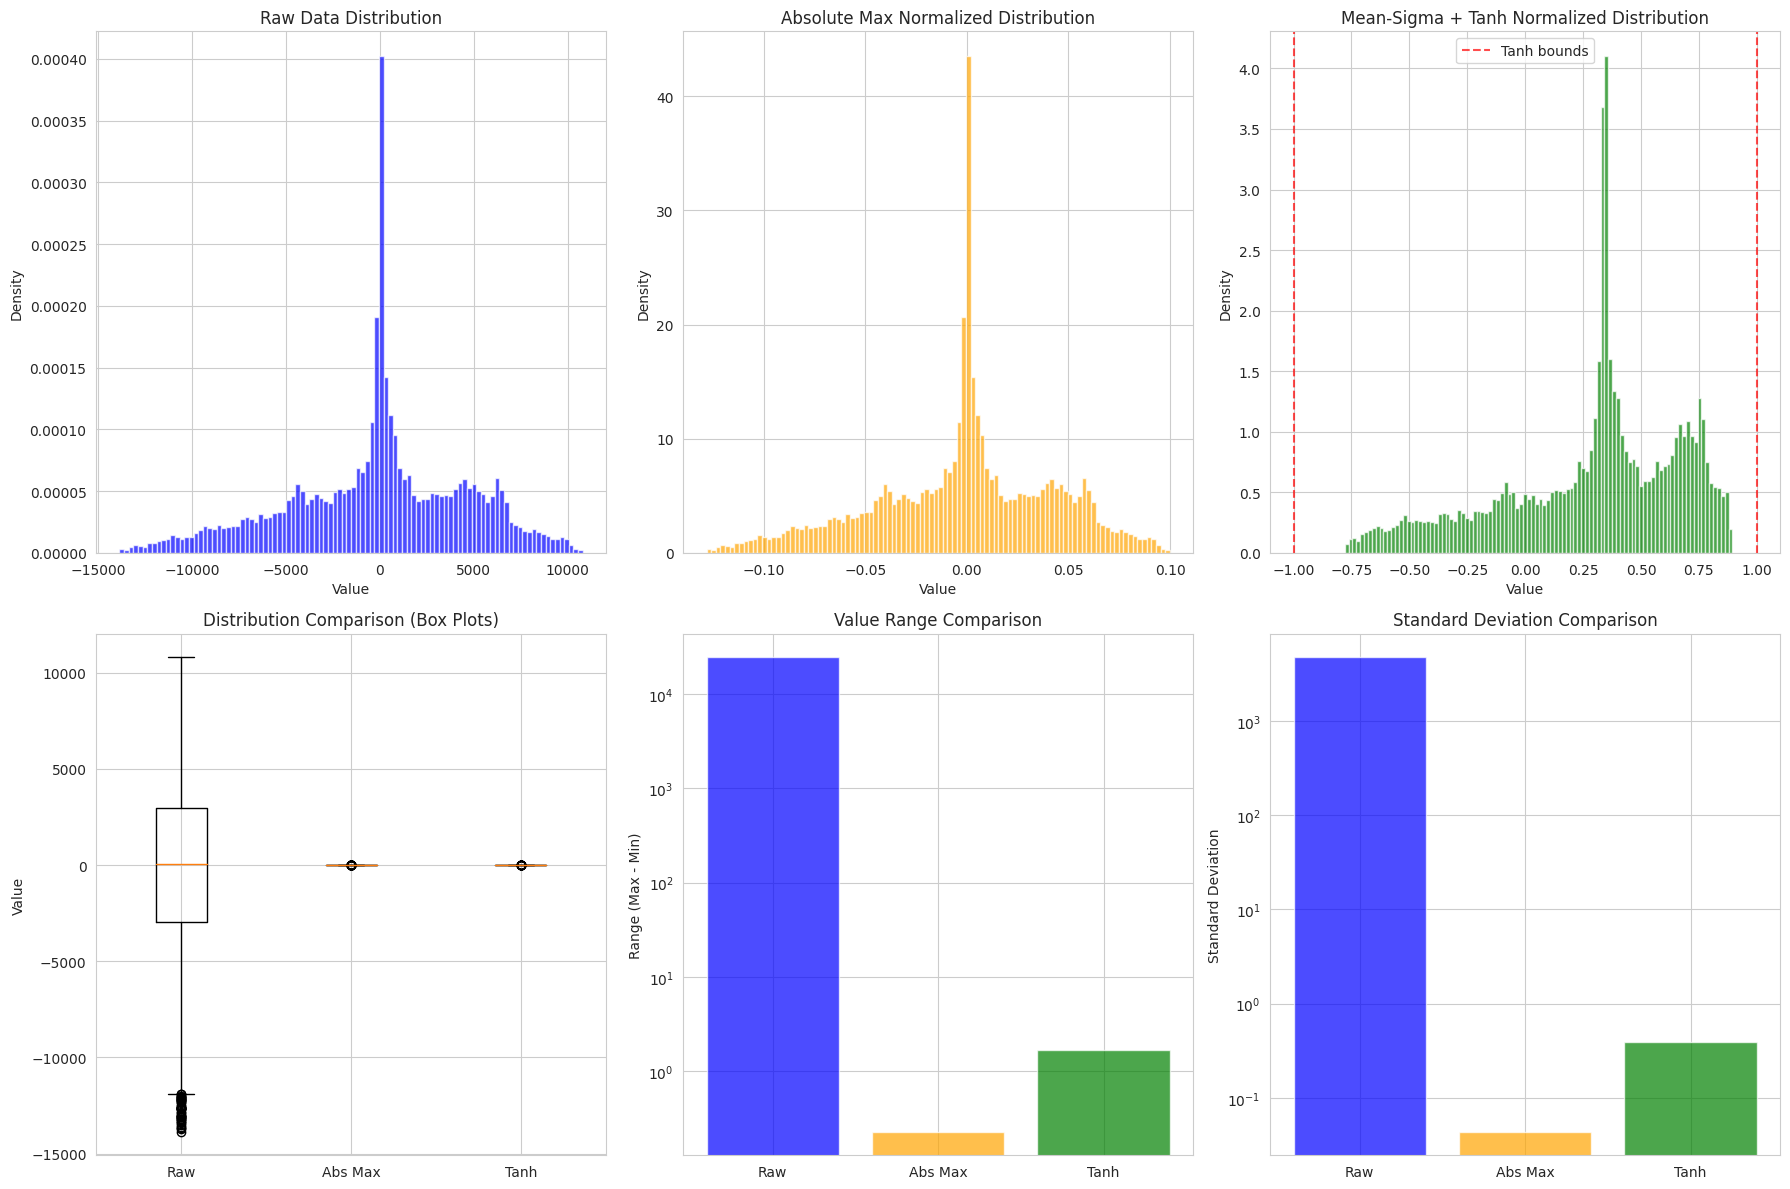


📊 Distribution Summary:
• Raw data preserves original physical scale
• Absolute max compresses to [0, 1] with std = 0.043728
• Tanh bounds to [-1, 1] with std = 0.386596
• Standard deviation ratio (Tanh/AbsMax): 8.84


In [8]:
# Analyze distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten all samples for distribution analysis
raw_flat = raw_sample.flatten().numpy()
abs_flat = abs_sample.flatten().numpy()
tanh_flat = tanh_sample.flatten().numpy()

# Top row: Histograms
axes[0, 0].hist(raw_flat, bins=100, alpha=0.7, color='blue', density=True)
axes[0, 0].set_title('Raw Data Distribution')
axes[0, 0].set_xlabel('Value')
axes[0, 0].set_ylabel('Density')

axes[0, 1].hist(abs_flat, bins=100, alpha=0.7, color='orange', density=True)
axes[0, 1].set_title('Absolute Max Normalized Distribution')
axes[0, 1].set_xlabel('Value')
axes[0, 1].set_ylabel('Density')

axes[0, 2].hist(tanh_flat, bins=100, alpha=0.7, color='green', density=True)
axes[0, 2].set_title('Mean-Sigma + Tanh Normalized Distribution')
axes[0, 2].set_xlabel('Value')
axes[0, 2].set_ylabel('Density')
axes[0, 2].axvline(-1, color='red', linestyle='--', alpha=0.7, label='Tanh bounds')
axes[0, 2].axvline(1, color='red', linestyle='--', alpha=0.7)
axes[0, 2].legend()

# Bottom row: Box plots and comparison
data_for_boxplot = [raw_flat[::10], abs_flat[::10], tanh_flat[::10]]  # Subsample
labels = ['Raw', 'Abs Max', 'Tanh']

axes[1, 0].boxplot(data_for_boxplot, labels=labels)
axes[1, 0].set_title('Distribution Comparison (Box Plots)')
axes[1, 0].set_ylabel('Value')

# Show value ranges
ranges = [
    raw_stats['max'] - raw_stats['min'],
    abs_stats['max'] - abs_stats['min'],
    tanh_stats['max'] - tanh_stats['min']
]
axes[1, 1].bar(labels, ranges, color=['blue', 'orange', 'green'], alpha=0.7)
axes[1, 1].set_title('Value Range Comparison')
axes[1, 1].set_ylabel('Range (Max - Min)')
axes[1, 1].set_yscale('log')

# Show standard deviations
stds = [raw_stats['std'], abs_stats['std'], tanh_stats['std']]
axes[1, 2].bar(labels, stds, color=['blue', 'orange', 'green'], alpha=0.7)
axes[1, 2].set_title('Standard Deviation Comparison')
axes[1, 2].set_ylabel('Standard Deviation')
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.show()

print(f"\n📊 Distribution Summary:")
print(f"• Raw data preserves original physical scale")
print(f"• Absolute max compresses to [0, 1] with std = {abs_stats['std']:.6f}")
print(f"• Tanh bounds to [-1, 1] with std = {tanh_stats['std']:.6f}")
print(f"• Standard deviation ratio (Tanh/AbsMax): {tanh_stats['std']/abs_stats['std']:.2f}")

## 7. Final Recommendations

In [ ]:
print("🎯 FINAL RECOMMENDATIONS")
print("=" * 60)

print("\n📋 SUMMARY:")
print(f"• Raw data range: [{raw_stats['min']:.0f}, {raw_stats['max']:.0f}]")
print(f"• Absolute max: [0, 1] with std = {abs_stats['std']:.6f}")
print(f"• Mean-sigma + tanh: [-1, 1] with std = {tanh_stats['std']:.6f}")

if 'is_reversible' in globals():
    print(f"• Tanh reversibility: {'✅ EXCELLENT' if is_reversible else '⚠️ CHECK ERRORS'}")
    if 'max_abs_error' in globals():
        print(f"  - Max error: {max_abs_error:.6f}")

# Decision logic
tanh_better = tanh_stats['std'] > abs_stats['std'] * 1.1  # 10% better threshold

print(f"\n🏆 RECOMMENDATION:")
if tanh_better:
    print(f"✅ **USE MEAN-SIGMA + TANH NORMALIZATION** because:")
    print(f"   • Preserves {tanh_stats['std']/abs_stats['std']:.1f}x more variance")
    print(f"   • Bounded [-1, 1] range is NN-friendly")
    print(f"   • Fully reversible for evaluation")
    print(f"   • Better handles extreme values")
else:
    print(f"⚖️  **BOTH METHODS ARE COMPARABLE**")
    print(f"   • Similar variance preservation")
    print(f"   • Choose based on your specific needs")

print(f"\n⚙️  TO USE IN YOUR TRAINING:")
print(f"```python")
print(f"# In your training script, add normalization_type parameter:")
print(f"train_dataset, train_sampler, train_dl = get_sequence_data_objects(")
print(f"    csv_path=args.csv_path,")
print(f"    transform_cond_csv=args.transform_cond_csv,")
print(f"    batch_size=args.batch_size,")
print(f"    distributed=False,")
print(f"    num_data_workers=args.num_workers,")
print(f"    split='train',")
print(f"    seed=42,")
print(f"    sequence_length=args.sequence_length,")
print(f"    transforms=True,")
print(f"    normalization_type='mean_sigma_tanh'  # 🚨 ADD THIS")
print(f")")
print(f"```")

print(f"\n🔬 TESTING SUGGESTIONS:")
print(f"• Run a few epochs with both methods and compare loss curves")
print(f"• Check gradient norms during training (tanh bounds may help)")
print(f"• Evaluate final model performance on validation set")
print(f"• For inference, use dataset.reverse_data_normalization() to get original scale")

if tanh_dataset.normalizer is not None:
    stats = tanh_dataset.normalizer.get_stats()
    print(f"\n📊 Your normalizer stats: mean={stats['mean']:.2f}, std={stats['std']:.2f}")
    print(f"   (These will be used consistently across train/val/test)")

In [ ]:
# Quick test: Show what happens to a few specific values
print("🧪 QUICK TEST: Value transformations")
print("=" * 40)

if tanh_dataset.normalizer is not None:
    test_values = torch.tensor([-50000., -1000., 0., 1000., 50000.])
    normalized = tanh_dataset.normalizer.forward(test_values)
    recovered = tanh_dataset.normalizer.reverse(normalized)
    
    print(f"{'Original':<12} {'Normalized':<12} {'Recovered':<12} {'Error':<12}")
    print("-" * 48)
    for i in range(len(test_values)):
        orig = test_values[i].item()
        norm = normalized[i].item()
        recov = recovered[i].item()
        error = abs(orig - recov)
        print(f"{orig:<12.1f} {norm:<12.6f} {recov:<12.1f} {error:<12.6f}")

print(f"\n💾 All results saved in variables for further analysis")
print(f"   • raw_sample, abs_sample, tanh_sample")
print(f"   • raw_stats, abs_stats, tanh_stats")
print(f"   • recovered_sample (if reversibility tested)")